# 0. Data Preprocessing

In [1]:
# !pip install wfdb

# Handle data path
from pathlib import Path

# Read and display data from Physionet
import wfdb
import pprint
import collections
from IPython.display import clear_output

# Data manipulation and plotting
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
from scipy.signal import butter,filtfilt

# Divide data into train and test set and save to HDF5
import h5py
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [2]:
raw_data_path = Path('./data/mit-bih-arrhythmia-database-1.0.0')
# main directory that store data
data_dir = Path('./data')
os.makedirs(data_dir, exist_ok=True)

# directory that store original MIT-BIH data

mit_arrh_dir = raw_data_path
os.makedirs(mit_arrh_dir, exist_ok=True)

# directory that store processed data
process_dir = data_dir / 'processed_data'
temp_dir = process_dir / 'temp'
os.makedirs(process_dir, exist_ok=True)

raw_data_dir = process_dir
os.makedirs(raw_data_dir, exist_ok=True)

In [3]:
def translate_beat_type(beat_type_arr, peak_loc_arr):
    n_type = ['N', 'L', 'R', 'e', 'j']
    s_type = ['A', 'a', 'J', 'S']
    v_type = ['V', 'E']
    f_type = ['F']
    q_type = ['/', 'f', 'Q']
    
    not_used = ['B', 'r', 'n', '?']
    
    encoded_label = []
    peak_loc_label = []
    ignored_label = []
    
    for beat_type, peak_loc in zip(beat_type_arr, peak_loc_arr):
        if beat_type in n_type:
            encoded_label.append(0)
        elif beat_type in s_type:
            encoded_label.append(1)
        elif beat_type in v_type:
            encoded_label.append(2)
        elif beat_type in f_type:
            encoded_label.append(3)
        elif beat_type in q_type:
            encoded_label.append(4)
        else:
            ignored_label.append(beat_type)
            continue
        peak_loc_label.append(peak_loc)
        
        
            
    encoded_label = np.array(encoded_label)
    peak_loc_label = np.array(peak_loc_label)

    return encoded_label, peak_loc_label, ignored_label
        

In [4]:
## Noted: This part of data is done incorrectly. The dataset should be split in train and test using records as follow instead of random split. The reason for this is from the paper:
## How the Choice of Samples for Building Arrhythmia Classifiers ImpactTheir Performances
## Train dataset record number: 101, 106, 108, 109, 112, 114, 115,116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215,220, 223, and 230,
## Test dataset record number: 100, 103, 105, 11, 113, 117, 121, 123, 200, 202, 210, 212, 213,214, 219, 221, 222, 228, 231, 232, and 234
## read data and annotation

file = open(mit_arrh_dir/'RECORDS')
record_list = file.read().splitlines()
file.close()
# progress bar to check if the program running
def update_progress(progress):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
bad_labels = []
with h5py.File(raw_data_dir / 'mit_raw_data.h5', 'w') as file:
    for i in range(len(record_list)):
        summary = wfdb.rdrecord(str(mit_arrh_dir / record_list[i])).__dict__
        
        ## only get the second signal which is ii - chest ECG
        anno = wfdb.rdann(str(mit_arrh_dir / record_list[i]), extension='atr', summarize_labels=True).__dict__
        peaks = anno['sample']
        labels = anno['symbol']
        encoded_labels, peak_labels, ignored_label = translate_beat_type(labels, peaks)
        bad_labels += ignored_label
        
        file.create_dataset('data/{:03d}'.format(i), data=summary['p_signal'][:, 0])
        file.create_dataset('peak/{:03d}'.format(i), data=peak_labels)
        file.create_dataset('label/{:03d}'.format(i), data=encoded_labels)
        
        update_progress((i+1) / float(len(record_list)))
        


Progress: [##################################################] 100.0%


In [5]:
import collections

def check_data_group(file):
    data_group = file['data']
    total = len(data_group.keys())
    index = 0
    total = []
    peaks = []
    for key in data_group.keys():
        temp_data = list(file['label/{}'.format(key)])
        total += temp_data
        temp_data = list(file['peak/{}'.format(key)])
        peaks += temp_data
    
    print(np.unique(total))
    print(collections.Counter(total))
    print(len(total) - collections.Counter(total)[5])
    print(len(peaks))
    print(len(total))

with h5py.File(raw_data_dir / 'mit_raw_data.h5', 'r') as file:
    check_data_group(file)
    
        


[0 1 2 3 4]
Counter({0: 90631, 4: 8043, 2: 7236, 1: 2781, 3: 803})
109494
109494
109494


In [6]:
def butter_highpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

# progress bar to check if the program running
def update_progress(progress):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

filtered_ecg_data = []
ecg_peak_annotations = []

with h5py.File(raw_data_dir / 'mit_raw_data.h5', 'r') as file:
    ## only get the second signal which is ii - chest ECG
    data_group = file['data']
    total = len(data_group.keys())
    index = 0
    for key in data_group.keys():
        temp_data = file['data/{}'.format(key)]
        filter_data = butter_highpass_filter(temp_data, 0.25, 360, 2)
        filtered_ecg_data.append(filter_data)
        temp_peak = file['peak/{}'.format(key)][:]
        ecg_peak_annotations.append(temp_peak)
        update_progress((index+1) / float(total))
        index += 1


Progress: [##################################################] 100.0%


In [7]:
def normalize(arr):
    arr_range = np.ptp(arr)
    arr_min = np.min(arr)
    norm_arr = (arr - arr_min) / float(arr_range)
    return norm_arr

ecg_data_norm = []
for i in range(len(filtered_ecg_data)):
    signal = normalize(filtered_ecg_data[i])
    ecg_data_norm.append(signal)
    update_progress( (i + 1) / float(len(filtered_ecg_data)))

Progress: [##################################################] 100.0%


In [8]:
## resample signal from 360 Hz to 125 Hz
def ecg_resample(data, input_freq, output_freq):
    data_len = len(data)
    resample_data_len = int(data_len / float(input_freq) * float(output_freq))
    resample_data = resample(data, resample_data_len)
    
    return resample_data

ecg_data_resample = []
for i in range(len(ecg_data_norm)):
    signal = ecg_resample(filtered_ecg_data[i], 360, 125)
    ecg_data_resample.append(signal)
    update_progress( (i + 1) / float(len(filtered_ecg_data)))
    
ecg_peak_loc_resample = []
for i in range(len(ecg_peak_annotations)):
    loc_resample = [int(x / float(360/125.)) for x in ecg_peak_annotations[i]]
    loc_resample = np.array(loc_resample)
    ecg_peak_loc_resample.append(loc_resample)
    update_progress((i+1)/float(len(ecg_peak_annotations)))

Progress: [##################################################] 100.0%


In [9]:
print(len(ecg_data_resample), len(ecg_peak_loc_resample))

48 48


In [10]:
def find_local_peak_location(beat_locs, ecg_sample, sample_freq):
    interval = 10 * sample_freq
    max_length = len(ecg_sample)
    correct_locs = []
    try:
        for i in range(len(beat_locs)):
            start_base_line = beat_locs[i] - interval / 2
            stop_base_line = beat_locs[i] + interval / 2
            
            # left end of data
            if start_base_line < 0 :
                stop_base_line += abs(start_base_line)
                start_base_line = 0

            # right end of data
            if stop_base_line >= max_length :
                start_base_line -= abs(stop_base_line - max_length)
                stop_base_line = max_length

            # local mean base line
            base_line = np.mean(ecg_sample[int(start_base_line):int(stop_base_line)])
            
            local_sample = None
            
            # left end of data
            if beat_locs[i] - 2 < 0:
                local_sample = ecg_sample[beat_locs[i] : beat_locs[i] + 5]
            
            # right end of data
            elif beat_locs[i] + 3 > max_length:
                local_sample = ecg_sample[beat_locs[i] - 5: beat_locs[i]]
            
            # normal case
            else:
                local_sample = ecg_sample[beat_locs[i] - 2: beat_locs[i] + 3]
                
            diff = [abs(x - base_line) for x in local_sample]
            max_loc = np.argmax(diff)
            new_loc = beat_locs[i] - 2 + max_loc
            correct_locs.append(new_loc)
    except:
        ## error case print stuff
        print(beat_locs[i])
        print(local_sample)
        print(base_line)
        print(diff)
        print(max_loc)
    correct_locs = np.array(correct_locs)
    return correct_locs

## Apply to the rest of the data
ecg_correct_peak_location = []
index = 0
for data, peak in zip(ecg_data_resample, ecg_peak_loc_resample):
    corrected_loc = find_local_peak_location(peak, data, 125)
    ecg_correct_peak_location.append(corrected_loc)
    index += 1
    update_progress((index)/ float(len(ecg_data_resample)))

# with h5py.File(raw_data_dir / 'mit_raw_data.h5', 'r') as file:
#     ## only get the second signal which is ii - chest ECG
#     data_group = file['peak']
#     total = len(data_group.keys())
#     index = 0
#     for key in data_group.keys():
#         temp_peak_data = file['peak/{}'.format(key)]
#         corrected_loc = find_local_peak_location(temp_peak_data, ecg_data_norm[int(key)], 360)
#         ecg_correct_peak_location.append(corrected_loc)
#         index += 1
#         update_progress((index)/ float(len(ecg_data_norm)))

Progress: [##################################################] 100.0%


In [11]:
print(len(ecg_correct_peak_location))

48


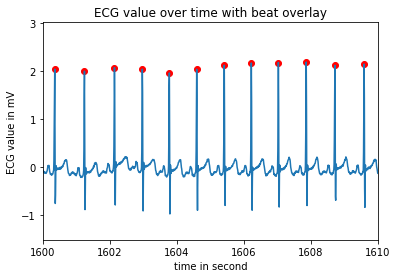

<Figure size 432x288 with 0 Axes>

In [12]:
## plot another sample

sample_num = 14
sample_freq = 125.
ecg_sample = ecg_data_resample[sample_num]
time_in_second = np.arange(0, len(ecg_sample)) / sample_freq

beat_loc_sample = ecg_correct_peak_location[sample_num]
beat_value = np.take(ecg_sample, beat_loc_sample, axis=0)
beat_location_in_second = beat_loc_sample / sample_freq

plt.plot(time_in_second, ecg_sample)
plt.scatter(beat_location_in_second, beat_value, c='r')
plt.xlim(1600, 1610)
plt.xlabel('time in second')
plt.ylabel('ECG value in mV')
plt.title('ECG value over time with beat overlay')
plt.show()
plt.clf()

In [13]:
## Extract signal beat by beat
"""
    ecg_data - ecg value for all record
    ecg_peak_annotations - beat location for all record
    beat_type_annotations - beat label for all record
"""

## We only looking to classify these 5 type from 0 to 4
accepted_labels = [0, 1, 2, 3, 4]

def check_for_array_overflow(end_position, max_len):
    if end_position > max_len:
        end_poistion = max_len
    return end_position

bad_label = []
## extract beat signal starting from peak of the beat to 1.2 * period where period is the interval between beat
def extract_beats(ecg_values, beat_locs, beat_labels, accepted_labels):
    signals = []
    labels = []
    max_len = len(ecg_values)
    # skip last beat since there is no follow-up beat after it
    for i in range(len(beat_locs) - 1):
        ## only handle beat with N, V, Q, S, F label
        if beat_labels[i] in accepted_labels:
            start = beat_locs[i]
            ## get 1.2 * interval between beat
            period = int((beat_locs[i+1] - beat_locs[i]) * 1.2)
            end = start + period
            end = check_for_array_overflow(end, max_len)
            
            signals.append(ecg_values[start: end])
            labels.append(beat_labels[i])
        else:
            bad_label.append(beat_labels[i])
    
    return signals, labels

# progress bar to check if the program running
def update_progress(progress):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
ecg_signals = []
ecg_labels = []


beat_type_annotations = []
with h5py.File(raw_data_dir / 'mit_raw_data.h5', 'r') as file:
    ## only get the second signal which is ii - chest ECG
    data_group = file['label']
    total = len(data_group.keys())
    index = 0
    for key in data_group.keys():
        temp_peak_data = file['label/{}'.format(key)][:]
        beat_type_annotations.append(temp_peak_data)
        index += 1
        update_progress((index)/ float(total))
        
    

for i in range(len(ecg_data_norm)):
    signal, label = extract_beats(ecg_data_resample[i], ecg_correct_peak_location[i], beat_type_annotations[i], accepted_labels)
    ecg_signals.append(signal)
    ecg_labels.append(label)
    update_progress((i + 1) / float(len(ecg_data_norm)))
    
## check if the data and label have equal length
print('Data length:', len(ecg_signals), 'Label length:', len(ecg_labels))

Progress: [##################################################] 100.0%
Data length: 48 Label length: 48


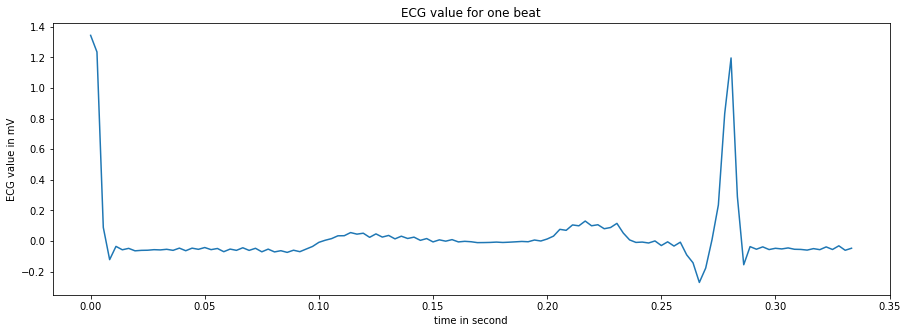

<Figure size 1080x360 with 0 Axes>

In [14]:
## plot one of the extract beat with length of 1.2 period
beat = ecg_signals[0][115]
# sampling frequency 360 Hz
time_in_seconds = np.arange(len(beat)) / 360.

plt.rcParams["figure.figsize"]= 15, 5
plt.plot(time_in_seconds, beat)
plt.xlabel('time in second')
plt.ylabel('ECG value in mV')
plt.title('ECG value for one beat')
plt.show()
plt.clf()

# 1. Data split

## 1.1 Inter-patient split

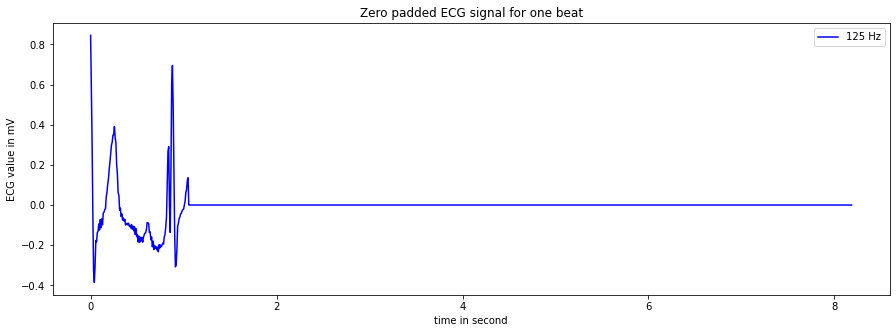

<Figure size 1080x360 with 0 Axes>

In [17]:
import copy
ecg_signals_zeropad = copy.deepcopy(ecg_signals)

for i in range(len(ecg_signals)):
    for j in range(len(ecg_signals[i])):

        zero_pad_max_length = 1024
        pad_length = zero_pad_max_length - len(ecg_signals[i][j])
        if pad_length <=0:
            zero_pad_data = ecg_signals[i][j][:zero_pad_max_length]
        else:
            zero_pad_data = np.pad(ecg_signals[i][j], (0,pad_length),'constant')
        ecg_signals_zeropad[i][j] = zero_pad_data
        

## plot a zero padded signal
ecg_sample = ecg_signals_zeropad[10][100]

# sampling frequency 125 Hz
time_in_second = np.arange(len(ecg_sample)) / 125.

plt.plot(time_in_second, ecg_sample, c='b', label='125 Hz')
plt.xlabel('time in second')
plt.ylabel('ECG value in mV')
plt.title('Zero padded ECG signal for one beat')
plt.legend()
plt.show()
plt.clf()

# ecg_signals_zeropad: 48 patients x number_of_beats x 256
# ecg_labels: 48 patients x number_of_beats

## Split train and test datasets with record number
## Train dataset record number: 101, 106, 108, 109, 112, 114, 115,116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215,220, 223, and 230,
## Test dataset record number: 100, 103, 105, 110, 113, 117, 121, 123, 200, 202, 210, 212, 213,214, 219, 221, 222, 228, 231, 232, and 234

train_record_list = [101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test_record_list = [100, 103, 105, 110, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213,214, 219, 221, 222, 228, 231, 232, 233, 234]
train_indices = [i for i in range(len(record_list)) if int(record_list[i]) in train_record_list]
test_indices = [i for i in range(len(record_list)) if int(record_list[i]) in test_record_list]

train_signals = [ecg_signals_zeropad[i][:][:] for i in train_indices]
train_labels = [ecg_labels[i][:] for i in train_indices]
test_signals = [ecg_signals_zeropad[i][:][:] for i in test_indices]
test_labels = [ecg_labels[i][:] for i in test_indices]

train_data = [beat_signal for patient in train_signals for beat_signal in patient]
train_labels = [beat_label for patient in train_labels for beat_label in patient]
test_data = [beat_signal for patient in test_signals for beat_signal in patient]
test_labels = [beat_label for patient in test_labels for beat_label in patient]

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# TODO:
# Save ECG 1D data sets
with h5py.File(process_dir / 'ECG_MIT-BIH_processed_data_interpatient_125Hz.h5', 'w') as file:
    train_set_d = file.create_dataset("train_data", data=train_data)
    train_set_l = file.create_dataset("train_labels", data=train_labels)
    test_set_d = file.create_dataset("test_data", data=test_data)
    test_set_l = file.create_dataset("test_labels", data=test_labels)

In [18]:
from collections import Counter

# Double check saved data
# read data from h5 file
file = h5py.File(process_dir / 'ECG_MIT-BIH_processed_data_interpatient_125Hz.h5', 'r')
train_set_d = file['train_data'][:]
train_set_l = file['train_labels'][:]
test_set_d = file['test_data'][:]
test_set_l = file['test_labels'][:]
file.close()

## Check length
print('Train data length:', train_set_d.shape)
print('Train label length:', train_set_l.shape)
print(Counter(train_set_l))
print('Test data length:', test_set_d.shape)
print('Test label length:', test_set_l.shape)
print(Counter(test_set_l))

    

Train data length: (50999, 1024)
Train label length: (50999,)
Counter({0: 45845, 2: 3788, 1: 943, 3: 415, 4: 8})
Test data length: (49690, 1024)
Test label length: (49690,)
Counter({0: 44238, 2: 3221, 1: 1836, 3: 388, 4: 7})


## 1.2 Intra-patient split

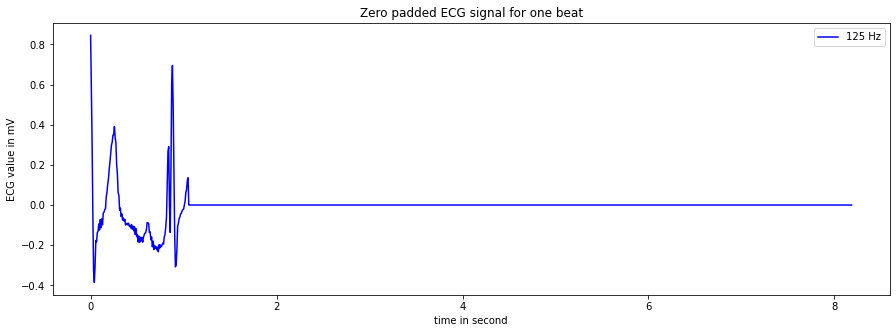

109446 109446


<Figure size 1080x360 with 0 Axes>

In [19]:
import copy
ecg_signals_zeropad = copy.deepcopy(ecg_signals)

for i in range(len(ecg_signals)):
    for j in range(len(ecg_signals[i])):

        zero_pad_max_length = 1024
        pad_length = zero_pad_max_length - len(ecg_signals[i][j])
        if pad_length <=0:
            zero_pad_data = ecg_signals[i][j][:zero_pad_max_length]
        else:
            zero_pad_data = np.pad(ecg_signals[i][j], (0,pad_length),'constant')
        ecg_signals_zeropad[i][j] = zero_pad_data
        

## plot a zero padded signal
ecg_sample = ecg_signals_zeropad[10][100]

# sampling frequency 125 Hz
time_in_second = np.arange(len(ecg_sample)) / 125.

plt.plot(time_in_second, ecg_sample, c='b', label='125 Hz')
plt.xlabel('time in second')
plt.ylabel('ECG value in mV')
plt.title('Zero padded ECG signal for one beat')
plt.legend()
plt.show()
plt.clf()


# ecg_signals_zeropad: 48 patients x number_of_beats x 2520
# ecg_labels: 48 patients x number_of_beats

## Split train and test datasets 80/20 stratified by class type
from sklearn.model_selection import StratifiedShuffleSplit

ecg_signals_zeropad_flatten = np.array([x for xs in ecg_signals_zeropad for x in xs])
ecg_labels_flatten = np.array([x for xs in ecg_labels for x in xs])

print(len(ecg_signals_zeropad_flatten), len(ecg_labels_flatten))

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(ecg_signals_zeropad_flatten, ecg_labels_flatten):
    train_signals, test_signals = ecg_signals_zeropad_flatten[train_index], ecg_signals_zeropad_flatten[test_index]
    train_labels, test_labels = ecg_labels_flatten[train_index], ecg_labels_flatten[test_index]
    
train_data = np.array(train_signals)
train_labels = np.array(train_labels)
test_data = np.array(test_signals)
test_labels = np.array(test_labels)

# Save ECG 1D data sets
with h5py.File(process_dir / 'ECG_MIT-BIH_processed_data_intrapatient_125Hz.h5', 'w') as file:
    train_set_d = file.create_dataset("train_data", data=train_data)
    train_set_l = file.create_dataset("train_labels", data=train_labels)
    test_set_d = file.create_dataset("test_data", data=test_data)
    test_set_l = file.create_dataset("test_labels", data=test_labels)

In [20]:
from collections import Counter

# Double check saved data
# read data from h5 file
file = h5py.File(process_dir / 'ECG_MIT-BIH_processed_data_intrapatient_125Hz.h5', 'r')
train_set_d = file['train_data'][:]
train_set_l = file['train_labels'][:]
test_set_d = file['test_data'][:]
test_set_l = file['test_labels'][:]
file.close()

## Check length
print('Train data length:', train_set_d.shape)
print('Train label length:', train_set_l.shape)
print(Counter(train_set_l))
print('Test data length:', test_set_d.shape)
print('Test label length:', test_set_l.shape)
print(Counter(test_set_l))

    

Train data length: (87556, 1024)
Train label length: (87556,)
Counter({0: 72471, 4: 6431, 2: 5789, 1: 2223, 3: 642})
Test data length: (21890, 1024)
Test label length: (21890,)
Counter({0: 18118, 4: 1608, 2: 1447, 1: 556, 3: 161})
